# FTP

In [3]:
_FTP_ = 225
_PATH_ = '/home/caster/training_data'

# Load dependencies

In [9]:
%run -i training_functions.py

In [10]:
t_data = read_intervals(_PATH_, _FTP_)

t_data[:10].drop(['watts_std', 'watts_25', 'watts_50', 'watts_75', 'watts_max', 'temp', 'hr_max'], axis=1)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in double_scalars


,filename,epoch_day,time,cad,hr,hr_min,hr_drift,km,kph,kilojoules,watts,np,alt,vi,tss,if,training_type
0,2017_02_18_11_13_04.utf8.json,17215,118,62.952481,151.204584,104,-0.233592,51.11070,25.871660,1064.2005,149.173045,227.744560,443.6,1.526714,152.671389,1.012198,Endurance
0,2017_02_22_17_33_49.utf8.json,17219,67,NaN,131.801924,90,NaN,24.28590,21.456039,NaN,NaN,NaN,390.6,NaN,NaN,NaN,NA
0,2017_03_07_17_47_18.utf8.json,17232,10,62.576433,137.426752,114,0.339606,4.69625,26.520306,93.3940,148.716561,216.195434,67.2,1.453741,0.000000,0.960869,Endurance
0,2017_03_07_17_47_18.utf8.json,17232,23,86.882497,171.672943,147,0.129740,18.93060,35.632825,310.9230,216.822176,234.398718,86,1.081064,0.000000,1.041772,FTP
0,2017_03_07_17_47_18.utf8.json,17232,46,71.348523,155.900576,126,-0.014478,37.26620,23.778161,400.1225,144.136347,235.856360,188.2,1.636342,0.000000,1.048250,Endurance
0,2017_03_10_17_46_57.utf8.json,17235,4,61.197761,138.582090,118,0.002620,0.91421,12.047118,42.8330,159.824627,221.239447,39.6,1.384264,0.000000,0.983286,Endurance
0,2017_03_10_17_46_57.utf8.json,17235,26,61.663425,145.644605,115,0.082763,23.27900,30.088589,174.7355,109.620765,186.888240,72.6,1.704862,0.000000,0.830614,Active recovery
0,2017_03_10_17_46_57.utf8.json,17235,20,80.738372,174.304817,138,0.146455,9.96009,26.927528,269.7650,224.057309,236.577337,158.6,1.055879,0.000000,1.051455,FTP
0,2017_03_11_17_34_54.utf8.json,17236,87,68.018194,135.779672,102,-0.012015,34.94850,23.891792,749.9425,142.873404,181.344455,501.2,1.269267,126.926670,0.805975,Endurance
0,2017_03_17_18_00_29.utf8.json,17242,16,81.361111,175.579293,157,0.178841,25.67930,38.147976,232.4320,234.779798,257.933357,39.6,1.098618,0.000000,1.146370,FTP


# Show plot with current data

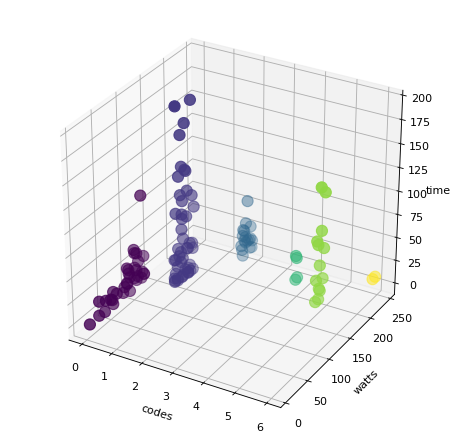

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

clean = t_data.drop(['filename', 'epoch_day', 'watts_std', 'watts_25', 'watts_50', 'watts_75', 'temp'], axis=1)

codes = pd.Categorical(clean.training_type)
cath = pd.DataFrame({"codes": codes.codes})

clean.reset_index(drop=True, inplace=True)
cath.reset_index(drop=True, inplace=True)
clean = pd.concat([clean, cath], axis=1)

# clean = clean[(clean.watts > 135) & (clean.time > 5)]

x_label = 'codes'
y_label = 'watts'
z_label = 'time'

x = clean[x_label]
y = clean[y_label]
z = clean[z_label]

fig = plt.figure(figsize=(7, 7), dpi=80)

ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_zlabel(z_label)


sc = StandardScaler()
ax.scatter(x, y, z, c=clean.codes, s=100)

plt.show()

# Reset data
# clean = pd.concat([clean.drop(['training_type'], axis=1), pd.get_dummies(clean.training_type)], axis=1)

# Clean dataset to use just the needed features

In [12]:
# load dataset
X = clean.drop(['cad', 'codes', 'training_type', 'hr_min', 'hr_max', 'hr_drift', 'km', 'kph', 'watts_max', 'alt', 'if', 'vi', 'tss', 'np', 'hr', 'kilojoules'], axis=1)
Y = clean.codes.values

temp = X
X = X.values
temp[:10]

,time,watts
0,118,149.173045
1,67,NaN
2,10,148.716561
3,23,216.822176
4,46,144.136347
5,4,159.824627
6,26,109.620765
7,20,224.057309
8,87,142.873404
9,16,234.779798


### Check if GPU is running and working

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1124415307788336250
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 1242562560
locality {
  bus_id: 1
}
incarnation: 4717084179925198589
physical_device_desc: "device: 0, name: GeForce GTX 965M, pci bus id: 0000:01:00.0"
]


# Classify

In [15]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import time

start_time = time.time()

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=2, activation='linear'))
    model.add(Dense(32, input_dim=16, activation='relu'))
    model.add(Dense(64, input_dim=32, activation='relu'))
    model.add(Dense(96, input_dim=64, activation='relu'))
    model.add(Dense(60, input_dim=96, activation='relu'))
    model.add(Dense(30, input_dim=60, activation='relu'))
    model.add(Dense(18, input_dim=30, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=30, batch_size=10, verbose=0)

kfold = KFold(n_splits=8, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)

print("Baseline: %.2f%% (%.2f%%) (%f)"  % (results.mean()*100, results.std()*100, time.time() - start_time))

Baseline: 40.31% (10.65%) (14.266841)


### Results

* Baseline: 53.86% (23.28%)
* Baseline: 67.39% (21.25%) epochs=50, batch_size=5 n_splits=5
* Baseline: 64.98% (22.11%) epochs=50, batch_size=7 n_splits=5
* Baseline: 56.72% (24.35%) epochs=50, batch_size=3 n_splits=5
* Baseline: 59.48% (25.49%) epochs=50, batch_size=3 n_splits=3
* Baseline: 72.48% (13.41%) epochs=50, batch_size=7 n_splits=7
* Baseline: 66.21% (22.48%) epochs=50, batch_size=10 n_splits=10
* Baseline: 74.23% (10.20%) epochs=50, batch_size=8 n_splits=8
* Baseline: 70.58% (17.30%) epochs=50, batch_size=9 n_splits=9
* **Baseline: 76.01% (11.91%) epochs=50, batch_size=9 n_splits=8**
* **Baseline: 77.74% (12.15%) epochs=50, batch_size=10 n_splits=8**
* Baseline: 72.43% (16.07%) epochs=50, batch_size=10 n_splits=7
* Baseline: 64.74% (21.36%) epochs=50, batch_size=10 n_splits=5
* Baseline: 66.23% (13.89%) epochs=50, batch_size=12 n_splits=7
* **Baseline: 75.16% (11.66%) epochs=50, batch_size=11 n_splits=7**
* Baseline: 68.86% (13.92%) epochs=30, batch_size=10 n_splits=7
* Baseline: 49.47% (17.67%) epochs=30, batch_size=10 n_splits=7 optimizer=sgd
* Baseline: 59.19% (10.75%) epochs=30, batch_size=10 n_splits=7 before_last_layer=activation=tanh
* Baseline: 66.18% (22.48%) epochs=30, batch_size=10 n_splits=7 input_layer=activation=relu
* Baseline: 60.82% (17.43%) epochs=30, batch_size=10 n_splits=7 second_layer=activation=linear
* **Baseline: 76.00% (11.40%) epochs=80, batch_size=10 n_splits=7**
* **Baseline: 75.12% (14.82%) epochs=80, batch_size=10 n_splits=8**
* Baseline: 73.27% (16.34%) epochs=80, batch_size=10 n_splits=8 optimizer=adamax
* **Baseline: 75.95% (11.90%) epochs=50, batch_size=10 n_splits=8**
* **Baseline: 77.74% (11.05%) epochs=150 batch_size=10 n_splits=8**
* **Baseline: 81.43% (9.37%) epochs=300 batch_size=10 n_splits=8**
* **Baseline: 76.90% (10.05%) epochs=600 batch_size=10 n_splits=8**
* **Baseline: 77.80% (8.45%) epochs=900 batch_size=10 n_splits=8**
* **Baseline: 79.52% (10.45%) epochs=300 batch_size=10 n_splits=8**
* **Baseline: 82.26% (8.05%) (103.422008) epochs=300 batch_size=10 n_splits-8 only 2 features (time and watts)**
* **Baseline: 83.04% (14.70%) (134.871115) epochs=300 batch_size=10 n_splits-8 only 2 features (time and watts)**
* **Baseline: 83.93% (8.56%) (132.833708) epochs=500 batch_size=10 n_splits-8 only 2 features (time and watts)**

> **Baseline: 83.93% (8.56%) (132.833708) epochs=500 batch_size=10 n_splits-8 only 2 features (time and watts)**